<a href="https://colab.research.google.com/github/IsharaSilva/Prediction-Recommedation-system-for-Potato-Cultivation/blob/main/Detection_of_Healthy_Unhealthy_Leaves.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [2]:
import cv2
import numpy as np # dataAnalysis
import pandas as pd #multidimensional arrays
import matplotlib.pyplot as plt #data visualization
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from skimage import img_as_ubyte
from skimage.util import img_as_float

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!git clone https://github.com/IsharaSilva/Prediction-Recommedation-system-for-Potato-Cultivation.git

Cloning into 'Prediction-Recommedation-system-for-Potato-Cultivation'...
remote: Enumerating objects: 167, done.
remote: Counting objects: 100% (54/54), done.
remote: Compressing objects: 100% (54/54), done.
remote: Total 167 (delta 34), reused 0 (delta 0), pack-reused 113
Receiving objects: 100% (167/167), 43.39 MiB | 24.11 MiB/s, done.
Resolving deltas: 100% (104/104), done.


In [4]:
from google.colab import drive

In [5]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
import os
path = os.listdir('/content/drive/MyDrive//Dataset/Training')
classes = {'Healthy':0, 'Virus':1, 'Fungal':2,'Insect':3}

**Image preprocessing and segmentation**

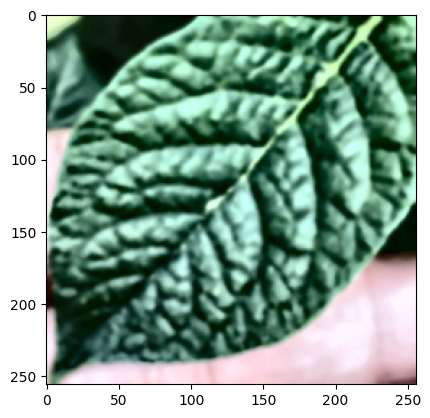

In [6]:
import cv2
import os
import numpy as np

input_dir = '/content/drive/MyDrive/Dataset/Training/'
output_dir = '/content/drive/MyDrive/Dataset/Preprocessed/'

# Create output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# Define the list of transformations
transformations = [
    ('rotation', cv2.ROTATE_90_CLOCKWISE),  # Rotate the image 90 degrees clockwise
    ('translation', np.float32([[1, 0, 50], [0, 1, 50]])),  # Translate the image by 50 pixels in both x and y directions
    ('scaling', np.float32([[0.5, 0, 0], [0, 0.5, 0]])),  # Scale down the image by 0.5
    ('flipping', 0),  # Flip the image horizontally
    ('noise', 30)  # Add Gaussian noise with mean=0 and standard deviation=30
]

x = []
y = []

for cls in classes:
    pth = os.path.join(input_dir, cls)
    for j in os.listdir(pth):
        img = cv2.imread(os.path.join(pth, j))
        img1 = cv2.resize(img, (256, 256))  # Image resizing
        img1 = cv2.medianBlur(img1, 5)  # Apply median filter to remove noise
        img1 = img_as_ubyte(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))  # Contrast improvement

        # Convert the image to LAB color space
        img1_lab = cv2.cvtColor(img1, cv2.COLOR_RGB2LAB)

        # Split the LAB image into separate channels
        img1_lab_planes = cv2.split(img1_lab)

        # Apply histogram equalization to the L channel
        img1_lab_planes = list(img1_lab_planes)
        img1_lab_planes[0] = cv2.equalizeHist(img1_lab_planes[0])
        img1_lab_planes = tuple(img1_lab_planes)

        # Merge the planes and convert back to RGB
        img1_lab = cv2.merge(img1_lab_planes)
        img1 = cv2.cvtColor(img1_lab, cv2.COLOR_LAB2RGB)

        # Smoothing
        img1 = cv2.GaussianBlur(img1, (5, 5), 0)

        # CLAHE (Contrast Limited Adaptive Histogram Equalization)
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        img1_lab_planes = cv2.split(cv2.cvtColor(img1, cv2.COLOR_RGB2LAB))
        img1_lab_planes = list(img1_lab_planes)
        img1_lab_planes[0] = clahe.apply(img1_lab_planes[0])
        img1_lab_planes = tuple(img1_lab_planes)
        img1_lab = cv2.merge(img1_lab_planes)
        img1 = cv2.cvtColor(img1_lab, cv2.COLOR_LAB2RGB)

        # Save preprocessed image
        output_path = os.path.join(output_dir, cls, j)
        os.makedirs(os.path.dirname(output_path), exist_ok=True)
        cv2.imwrite(output_path, img1)

        # Append the preprocessed image and original image to the lists
        x.append(img1)
        y.append(img)

        # Apply transformations to the image
        for transform_name, transform_param in transformations:
            transformed_img = img1.copy()

            if transform_name == 'rotation':
                transformed_img = cv2.rotate(transformed_img, transform_param)
            elif transform_name == 'translation':
                M = transform_param
                transformed_img = cv2.warpAffine(transformed_img, M, (img1.shape[1], img1.shape[0]))
            elif transform_name == 'scaling':
                M = transform_param
                transformed_img = cv2.warpAffine(transformed_img, M, (int(img1.shape[1]*0.5), int(img1.shape[0]*0.5)))
            elif transform_name == 'flipping':
                transformed_img = cv2.flip(transformed_img, transform_param)
            elif transform_name == 'noise':
                noise = np.random.normal(0, transform_param, img1.shape).astype(np.uint8)
                transformed_img = cv2.add(transformed_img, noise)

            # Save the transformed image
            output_path = os.path.join(output_dir, cls, f'{transform_name}_{j}')
            cv2.imwrite(output_path, transformed_img)

# Display the preprocessed image
plt.imshow(x[0])


**Feature extraction**

In [ ]:
from skimage.feature import greycomatrix, greycoprops
import cv2
import os

preprocessed_dir = '/content/drive/MyDrive/Dataset/Preprocessed/'
glcm_features = []
labels = []

# Define GLCM parameters
distances = [1]
angles = [0]

for cls in classes:
    pth = os.path.join(preprocessed_dir, cls)
    for j in os.listdir(pth):
        img_path = os.path.join(pth, j)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

        # Compute GLCM
        glcm = greycomatrix(img, distances=distances, angles=angles, levels=256, symmetric=True, normed=True)
        
        # Compute GLCM properties
        contrast = greycoprops(glcm, prop='contrast')[0, 0]
        dissimilarity = greycoprops(glcm, prop='dissimilarity')[0, 0]
        homogeneity = greycoprops(glcm, prop='homogeneity')[0, 0]
        energy = greycoprops(glcm, prop='energy')[0, 0]
        correlation = greycoprops(glcm, prop='correlation')[0, 0]

        glcm_features.append([contrast, dissimilarity, homogeneity, energy, correlation])
        labels.append(cls)  # Assign label based on the class

# Print GLCM features and labels for each image
for i, features in enumerate(glcm_features):
    print(f"Image {i+1}: Contrast={features[0]}, Dissimilarity={features[1]}, Homogeneity={features[2]}, Energy={features[3]}, Correlation={features[4]}, Label={labels[i]}")


Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0

Image 1: Contrast=10.755074148296593, Dissimilarity=1.893799599198397, Homogeneity=0.5025844149703966, Energy=0.14079425558428335, Correlation=0.9826718189442811, Label=Healthy
Image 2: Contrast=6.33749498997996, Dissimilarity=1.4256953907815633, Homogeneity=0.5422120651492822, Energy=0.07534558178787282, Correlation=0.9920663845434442, Label=Healthy
Image 3: Contrast=9.36903006012024, Dissimilarity=1.6361643286573149, Homogeneity=0.5654219390255415, Energy=0.17068762355331385, Correlation=0.9912333607997438, Label=Healthy
Image 4: Contrast=15.090557114228456, Dissimilarity=1.5431022044088176, Homogeneity=0.6710488432459966, Energy=0.465417150102943, Correlation=0.9849410236091581, Label=Healthy
Image 5: Contrast=14.769130260521038, Dissimilarity=1.5002885771543084, Homogeneity=0.693178164001931, Energy=0.5119805473287522, Correlation=0.9888352270278835, Label=Healthy
Image 6: Contrast=16.878709418837676, Dissimilarity=2.060376753507014, Homogeneity=0.5650585159867034, Energy=0.3363362

**Extract color-based features - Color Co-occurrence Matrix (CCM)**

In [ ]:
import os
import cv2
import numpy as np
from skimage.feature import greycomatrix, greycoprops

# Set the number of levels for each color channel
num_levels = 8

# Set the distance and angle offsets for co-occurrence calculation
distances = [1]
angles = [0, np.pi/4, np.pi/2, 3*np.pi/4]

# Define the directory path containing the color images
image_dir = '/content/drive/MyDrive/Dataset/Preprocessed/'

# Collect image data
image_data = []
for cls in classes:
    class_dir = os.path.join(image_dir, cls)
    for filename in os.listdir(class_dir):
        image_path = os.path.join(class_dir, filename)
        img = cv2.imread(image_path)
        img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # Convert to grayscale

        # Rescale the grayscale image values to fit within the range of 0 to num_levels - 1
        img_rescaled = (img_gray / 255 * (num_levels - 1)).astype(np.uint8)

        image_data.append(img_rescaled)

# Compute the Color Co-occurrence Matrix (CCM) properties
ccm_features = []
for img_rescaled in image_data:
    # Compute the Color Co-occurrence Matrix (CCM)
    ccm = greycomatrix(img_rescaled, distances=distances, angles=angles, levels=num_levels, symmetric=True, normed=True)

    # Compute the CCM properties (e.g., contrast, dissimilarity, homogeneity, energy, correlation)
    contrast = greycoprops(ccm, prop='contrast')[0, 0]
    dissimilarity = greycoprops(ccm, prop='dissimilarity')[0, 0]
    homogeneity = greycoprops(ccm, prop='homogeneity')[0, 0]
    energy = greycoprops(ccm, prop='energy')[0, 0]
    correlation = greycoprops(ccm, prop='correlation')[0, 0]

    # Collect the CCM properties as features
    ccm_features.append([contrast, dissimilarity, homogeneity, energy, correlation])

# Print the CCM features for each image
for i, features in enumerate(ccm_features):
    print(f"Image {i+1}: Contrast={features[0]}, Dissimilarity={features[1]}, Homogeneity={features[2]}, Energy={features[3]}, Correlation={features[4]}")


Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0

Image 1: Contrast=0.05645691382765531, Dissimilarity=0.056272545090180356, Homogeneity=0.9718821643286573, Energy=0.6435178822550848, Correlation=0.9190535248969177
Image 2: Contrast=0.04685370741482966, Dissimilarity=0.04625250501002004, Homogeneity=0.9769338677354709, Energy=0.7136000090525416, Correlation=0.9587772532532287
Image 3: Contrast=0.053034068136272546, Dissimilarity=0.0524248496993988, Homogeneity=0.973848496993988, Energy=0.7206878602471829, Correlation=0.9419465876577215
Image 4: Contrast=0.04934669338677355, Dissimilarity=0.04932264529058116, Homogeneity=0.9753410821643287, Energy=0.6434390342745374, Correlation=0.948425479569858
Image 5: Contrast=0.02529058116232465, Dissimilarity=0.02529058116232465, Homogeneity=0.9873547094188377, Energy=0.7426429069661404, Correlation=0.9814544588518699
Image 6: Contrast=0.04390380761523046, Dissimilarity=0.043687374749499, Homogeneity=0.9781779559118235, Energy=0.6449838475417073, Correlation=0.9550496621710397
Image 7: Contrast=0

In [ ]:
import os
import cv2
from skimage.feature import greycomatrix, greycoprops

preprocessed_dir = '/content/drive/MyDrive/Dataset/Preprocessed/'
haralick_features = []
labels = []

# Haralick texture feature parameters
distances = [1]
angles = [0]

for cls in classes:
    pth = os.path.join(preprocessed_dir, cls)
    for j in os.listdir(pth):
        img_path = os.path.join(pth, j)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

        # Compute GLCM
        glcm = greycomatrix(img, distances=distances, angles=angles, levels=256, symmetric=True, normed=True)
        
        # Compute Haralick texture features
        haralick = greycoprops(glcm, prop='contrast')[0, 0], greycoprops(glcm, prop='dissimilarity')[0, 0], \
                   greycoprops(glcm, prop='homogeneity')[0, 0], greycoprops(glcm, prop='energy')[0, 0], \
                   greycoprops(glcm, prop='correlation')[0, 0]

        haralick_features.append(haralick)
        labels.append(cls)  # Assign label based on the class

# Print Haralick texture features and labels for each image
for i, features in enumerate(haralick_features):
    print(f"Image {i+1}: Haralick Features={features}, Label={labels[i]}")



Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0

Image 1: Haralick Features=(10.755074148296593, 1.893799599198397, 0.5025844149703966, 0.14079425558428335, 0.9826718189442811), Label=Healthy
Image 2: Haralick Features=(6.33749498997996, 1.4256953907815633, 0.5422120651492822, 0.07534558178787282, 0.9920663845434442), Label=Healthy
Image 3: Haralick Features=(9.36903006012024, 1.6361643286573149, 0.5654219390255415, 0.17068762355331385, 0.9912333607997438), Label=Healthy
Image 4: Haralick Features=(15.090557114228456, 1.5431022044088176, 0.6710488432459966, 0.465417150102943, 0.9849410236091581), Label=Healthy
Image 5: Haralick Features=(14.769130260521038, 1.5002885771543084, 0.693178164001931, 0.5119805473287522, 0.9888352270278835), Label=Healthy
Image 6: Haralick Features=(16.878709418837676, 2.060376753507014, 0.5650585159867034, 0.3363362072466224, 0.9841599834021273), Label=Healthy
Image 7: Haralick Features=(7.27730260521042, 1.1577915831663328, 0.6853193725985303, 0.26869109690236515, 0.9901796127443199), Label=Healthy
Image

**contrast, dissimilarity, homogeneity, energy, and correlation, ASM, entropy, mean hue, mean red, mean green, mean blue, standard deviation hue, standard deviation red, standard deviation green, and standard deviation blue.**

In [7]:
from skimage.feature import greycomatrix, greycoprops
from skimage.measure import shannon_entropy
import cv2
import os

preprocessed_dir = '/content/drive/MyDrive/Dataset/Preprocessed/'
features = []
labels = []

# GLCM parameters
distances = [1]
angles = [0]

for cls in classes:
    pth = os.path.join(preprocessed_dir, cls)
    for j in os.listdir(pth):
        img_path = os.path.join(pth, j)
        img = cv2.imread(img_path)

        # Split RGB image into channels
        blue, green, red = cv2.split(img)

        # Calculate mean and standard deviation for each channel
        mean_blue = blue.mean()
        mean_green = green.mean()
        mean_red = red.mean()
        std_dev_blue = blue.std()
        std_dev_green = green.std()
        std_dev_red = red.std()

        # Convert RGB image to HSV
        hsv_img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

        # Split HSV image into channels
        hue, saturation, value = cv2.split(hsv_img)

        # Calculate mean hue
        mean_hue = hue.mean()

        # Convert RGB image to grayscale
        gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Compute GLCM
        glcm = greycomatrix(gray_img, distances=distances, angles=angles, levels=256, symmetric=True, normed=True)
        
        # Compute GLCM properties
        contrast = greycoprops(glcm, prop='contrast')[0, 0]
        dissimilarity = greycoprops(glcm, prop='dissimilarity')[0, 0]
        homogeneity = greycoprops(glcm, prop='homogeneity')[0, 0]
        energy = greycoprops(glcm, prop='energy')[0, 0]
        correlation = greycoprops(glcm, prop='correlation')[0, 0]

        # Calculate ASM and entropy
        asm = (glcm**2).sum()
        entropy = shannon_entropy(gray_img)

        # Store the extracted features and labels
        feature = [
            contrast, dissimilarity, homogeneity, energy, correlation,
            asm, entropy,
            mean_hue, mean_red, mean_green, mean_blue,
            std_dev_red, std_dev_green, std_dev_blue
        ]
        features.append(feature)
        labels.append(cls)

# Print the extracted features and labels for each image
for i, feature in enumerate(features):
    print(f"Image {i+1}: Features={feature}, Label={labels[i]}")


Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0

Streaming output truncated to the last 5000 lines.
Image 2573: Features=[842.1966658464565, 19.554810531496063, 0.10335766314305865, 0.012818692254602687, 0.9058311226271514, 0.00016431887111821093, 7.760567422616096, 72.4366455078125, 69.09197998046875, 123.56219482421875, 95.318603515625, 59.44361392496705, 71.17033075964065, 69.4243414807949], Label=Virus
Image 2574: Features=[229.74715073529418, 10.025490196078433, 0.17861022971641127, 0.016355301893099305, 0.9744019865893044, 0.00026749590001441757, 7.770211691972332, 72.44316101074219, 68.77981567382812, 123.54078674316406, 95.2879638671875, 59.26589620468537, 71.41024471023991, 69.75907653445609], Label=Virus
Image 2575: Features=[4246.283287377451, 47.645603553921575, 0.044462149664300024, 0.009922870767244948, 0.3483262474256398, 9.846336426344435e-05, 7.442046904371247, 77.561767578125, 167.4964141845703, 195.82421875, 182.0665283203125, 61.042526824633235, 59.15003214792521, 60.284060897545736], Label=Virus
Image 2576: Featu

**Classification**

In [8]:
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Load the dataset
X = np.array(features)  # Features matrix
y = np.array(labels)  # Target vector (labels)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create an SVM classifier
clf = svm.SVC()

# Train the classifier
clf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

# Evaluate the model
report = classification_report(y_test, y_pred)
print("Accuracy:", accuracy)
print("Classification Report:")
print(report)

Accuracy: 0.4521452145214521
Classification Report:
              precision    recall  f1-score   support

      Fungal       0.55      0.71      0.62       346
     Healthy       0.39      0.05      0.09       394
      Insect       0.59      0.09      0.16       366
       Virus       0.40      0.94      0.56       409

    accuracy                           0.45      1515
   macro avg       0.48      0.45      0.36      1515
weighted avg       0.48      0.45      0.36      1515



**Multi-class support vector machine (SVM) using the linear kernel function**

In [9]:
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Load the dataset
X = np.array(features)  # Features matrix
y = np.array(labels)  # Target vector (labels)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create an SVM classifier with linear kernel
clf = svm.SVC(kernel='linear')

# Train the classifier
clf.fit(X_train, y_train)

# Make predictions on the test set
accuracy = accuracy_score(y_test, y_pred)
y_pred = clf.predict(X_test)

# Evaluate the model
report = classification_report(y_test, y_pred)
print("Accuracy:", accuracy)
print("Classification Report:")
print(report)

Accuracy: 0.4521452145214521
Classification Report:
              precision    recall  f1-score   support

      Fungal       0.83      0.94      0.88       346
     Healthy       0.81      0.41      0.54       394
      Insect       0.59      0.52      0.55       366
       Virus       0.52      0.76      0.62       409

    accuracy                           0.65      1515
   macro avg       0.69      0.66      0.65      1515
weighted avg       0.68      0.65      0.64      1515



In [10]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

# Convert the feature list and labels to numpy arrays
X = np.array(features)
y = np.array(labels)

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the classifier
rf_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_classifier.predict(X_test)

# Evaluate the classifier
accuracy = accuracy_score(y_test, y_pred)
classification_report = classification_report(y_test, y_pred)

print("Accuracy:", accuracy)
print("Classification Report:")
print(classification_report)


Accuracy: 0.9141914191419142
Classification Report:
              precision    recall  f1-score   support

      Fungal       0.96      0.99      0.98       346
     Healthy       0.95      0.80      0.87       394
      Insect       0.93      0.93      0.93       366
       Virus       0.83      0.94      0.88       409

    accuracy                           0.91      1515
   macro avg       0.92      0.92      0.92      1515
weighted avg       0.92      0.91      0.91      1515



In [11]:
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

# Convert the feature list and labels to numpy arrays
X = np.array(features)
y = np.array(labels)

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a Decision Tree classifier
dt_classifier = DecisionTreeClassifier()

# Train the classifier
dt_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = dt_classifier.predict(X_test)

# Evaluate the classifier
accuracy = accuracy_score(y_test, y_pred)
classification_report = classification_report(y_test, y_pred)

print("Accuracy:", accuracy)
print("Classification Report:")
print(classification_report)


Accuracy: 0.8739273927392739
Classification Report:
              precision    recall  f1-score   support

      Fungal       0.93      0.97      0.95       346
     Healthy       0.86      0.81      0.83       394
      Insect       0.87      0.92      0.89       366
       Virus       0.83      0.81      0.82       409

    accuracy                           0.87      1515
   macro avg       0.88      0.88      0.88      1515
weighted avg       0.87      0.87      0.87      1515



In [12]:
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

# Convert the feature list and labels to numpy arrays
X = np.array(features)
y = np.array(labels)

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a KNN classifier
knn_classifier = KNeighborsClassifier(n_neighbors=5)

# Train the classifier
knn_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = knn_classifier.predict(X_test)

# Evaluate the classifier
accuracy = accuracy_score(y_test, y_pred)
classification_report = classification_report(y_test, y_pred)

print("Accuracy:", accuracy)
print("Classification Report:")
print(classification_report)


Accuracy: 0.6712871287128713
Classification Report:
              precision    recall  f1-score   support

      Fungal       0.85      0.85      0.85       346
     Healthy       0.56      0.57      0.57       394
      Insect       0.68      0.75      0.71       366
       Virus       0.61      0.55      0.58       409

    accuracy                           0.67      1515
   macro avg       0.68      0.68      0.68      1515
weighted avg       0.67      0.67      0.67      1515

